In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.ops import nms
import os
import numpy as np
import cv2
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision 
from torchvision import transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt 
from PIL import Image

In [2]:
path = "/kaggle/input/cat-dataset/CAT_00"
file_list = []
y_list = []

for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith(".jpg"):
            file_list.append(os.path.join(root, file))
            y_file = file+'.cat'  # create the expected .cat file name
            y_file_path = os.path.join(root, y_file)  # create full path to the .cat file
            if os.path.isfile(y_file_path):  # check if the .cat file exists
                y_list.append(y_file_path)


In [3]:
class cat_ds(Dataset):
    def __init__(self,pic_names, y_names, img_size):
        super().__init__()
        self.pic_list , self.y_list = pic_names, y_names
        self.transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        ])
        
        self.image_size = img_size
 
    def __getitem__(self, idx):
        image = Image.open(self.pic_list[idx])
        y = self.y_list[idx]
        with open(y_file_path, 'r') as f:
            content = f.read()
        y = [int(c) for c in content.split(' ')[0:-1]]
        n = y[0]
        y =torch.tensor([y[i:i + 2] for i in range(1, len(y), 2)])
        w, h = image.size
        # scale the coordinates based on img
        ratiox = w/self.image_size
        ratioy = h/self.image_size
        y[:,0] = y[:,0]/ratiox
        y[:,1] = y[:,1]/ratioy
        return self.transform(image), torch.tensor(y)
    
        
    def __len__(self):
        return len(self.pic_list)
   

In [4]:
batch_size = 16
dataset = cat_ds(file_list, y_list, 416)
train_dataset, test_dataset = random_split(dataset,[0.8, 0.2])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [5]:
dataset[4][0].shape

/tmp/ipykernel_34/265852567.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(image), torch.tensor(y)


torch.Size([3, 416, 416])

In [6]:

class ResNet50Backbone(nn.Module):
    def __init__(self):
        super(ResNet50Backbone, self).__init__()
        resnet = models.resnet50(pretrained=True)
        # Extract layers from ResNet-50
        self.layer1 = nn.Sequential(*list(resnet.children())[:5])  # Until layer1
        self.layer2 = nn.Sequential(*list(resnet.children())[5])   # layer2
        self.layer3 = nn.Sequential(*list(resnet.children())[6])   # layer3
        self.layer4 = nn.Sequential(*list(resnet.children())[7])   # layer4

    def forward(self, x):
        c1 = self.layer1(x)
        c2 = self.layer2(c1)
        c3 = self.layer3(c2)
        c4 = self.layer4(c3)
        return c1, c2, c3, c4

class FeaturePyramidNetwork(nn.Module):
    def __init__(self, in_channels_list, out_channels):
        super(FeaturePyramidNetwork, self).__init__()
        self.inner_blocks = nn.ModuleList()
        self.layer_blocks = nn.ModuleList()
        
        for in_channels in in_channels_list:
            self.inner_blocks.append(nn.Conv2d(in_channels, out_channels, 1))
            self.layer_blocks.append(nn.Conv2d(out_channels, out_channels, 3, padding=1))
    
    def forward(self, x):
        # Get feature maps from the backbone
        c1, c2, c3, c4 = x
        
        p4 = self.inner_blocks[3](c4)
        p3 = self.inner_blocks[2](c3) + nn.functional.interpolate(p4, scale_factor=2, mode="nearest")
        p2 = self.inner_blocks[1](c2) + nn.functional.interpolate(p3, scale_factor=2, mode="nearest")
        p1 = self.inner_blocks[0](c1) + nn.functional.interpolate(p2, scale_factor=2, mode="nearest")
        
        p1 = self.layer_blocks[0](p1)
        p2 = self.layer_blocks[1](p2)
        p3 = self.layer_blocks[2](p3)
        p4 = self.layer_blocks[3](p4)
        
        return p1, p2, p3, p4


class DetectionHead(nn.Module):
    def __init__(self, in_channels, num_anchors, num_classes):
        super(DetectionHead, self).__init__()
        self.cls_head = nn.Conv2d(in_channels, num_classes, 1)
        self.reg_head = nn.Conv2d(in_channels, num_anchors * 2, 1)

    def forward(self, x):
        cls_logits = [self.cls_head(fmap) for fmap in x]
        bbox_regs = [self.reg_head(fmap) for fmap in x]
        
        return cls_logits, bbox_regs

num_classes = 2  # 1 class (cat) + background
num_anchors = 9  # Example number of anchors
backbone = ResNet50Backbone()
fpn = FeaturePyramidNetwork([256, 512, 1024, 2048], 256)
detection_head = DetectionHead(256, num_anchors, num_classes)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 144MB/s] 


In [9]:
class ObjectDetectionModel(nn.Module):
    def __init__(self, backbone, fpn, detection_head):
        super(ObjectDetectionModel, self).__init__()
        self.backbone = backbone
        self.fpn = fpn
        self.detection_head = detection_head
        self.downsample = nn.Conv2d(72, 72//4, kernel_size=1, stride=1)
        self.downsample2 = nn.Conv2d(8, 8//4, kernel_size=1, stride=1)
    
    def forward(self, x):
        features = self.backbone(x)
        fpn_features = self.fpn(features)
        cls_logits_list, bbox_regs_list = self.detection_head(fpn_features)
        
        
        # Interpolate each level's outputs to the size of the first feature map
        target_size = fpn_features[0].shape[-2:]
        cls_logits = torch.cat([F.interpolate(logits, size=target_size, mode='bilinear', align_corners=False) for logits in cls_logits_list], dim=1)
        bbox_regs = torch.cat([F.interpolate(regs, size=target_size, mode='bilinear', align_corners=False) for regs in bbox_regs_list], dim=1)
        #print('ddd',bbox_regs.shape)
        bbox_regs = self.downsample(bbox_regs)
        #print('ddd',bbox_regs.shape)
        cls_logits = self.downsample2(cls_logits)
        
        bbox_regs = bbox_regs.permute((0,2,3,1)) #(batch, maps*cordinate_num*coordinate_vals, w1,w2)->(B, w1,w2, maps*cordinate_num*coordinate_vals)
        cls_logits = cls_logits.permute((0,2,3,1))
        batch,w1,w2,c = bbox_regs.shape #(B, w1,w2, maps*cordinate_num*coordinate_vals)
        bbox_regs = bbox_regs.view((batch,w1*w2,c//2,2))
        
        batch,w1,w2,c = cls_logits.shape #(B, w1,w2, maps*cordinate_num*coordinate_vals)
        cls_logits = cls_logits.view((batch,w1*w2,c//2,2))
        return cls_logits.squeeze(2), bbox_regs

model = ObjectDetectionModel(backbone, fpn, detection_head)

In [12]:
# Move model to the right device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Loss and optimizer
criterion_cls = nn.CrossEntropyLoss()
criterion_reg = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)

# Training loop
num_epochs = 10
losses = []
for epoch in range(num_epochs):
    model.train()
    for images, targets in train_loader:
        images = images.to(device).to(torch.float32)
        targets = targets.to(device).to(torch.float32)
        #print(targets.shape)
        cls_logits, bbox_regs = model(images)
        
        targets = torch.stack([targets for _ in range(bbox_regs.shape[1])], dim=1)
        #print(targets.shape, cls_logits.shape,cls_logits[1].shape,
        #      bbox_regs.shape, bbox_regs[1].shape, bbox_regs[2].shape, bbox_regs[3].shape)
        
        
        loss_cls = criterion_cls(cls_logits, torch.zeros_like(cls_logits))
        loss_reg = criterion_reg(bbox_regs, targets)
        
        loss = loss_cls + loss_reg
        losses.append(loss_cls.item() + loss_reg.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Save the model
torch.save(model.state_dict(), 'object_detection_model.pth')


/tmp/ipykernel_34/265852567.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(image), torch.tensor(y)


Epoch [1/10], Loss: 76.8506
Epoch [2/10], Loss: 76.1981
Epoch [3/10], Loss: 50.6372
Epoch [4/10], Loss: 43.3980
Epoch [5/10], Loss: 71.4060
Epoch [6/10], Loss: 56.5851
Epoch [7/10], Loss: 19.7777
Epoch [8/10], Loss: 55.0754
Epoch [9/10], Loss: 37.6772
Epoch [10/10], Loss: 51.6906


/tmp/ipykernel_34/265852567.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(image), torch.tensor(y)


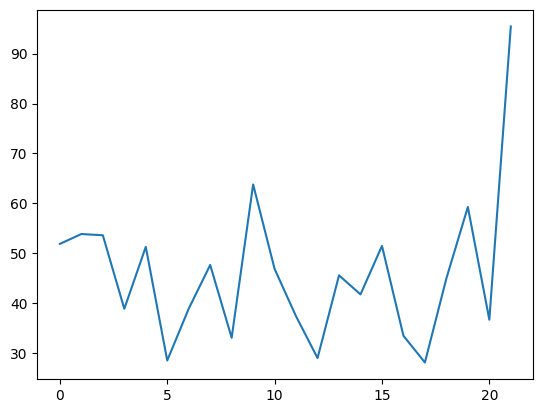

In [14]:
t_losses = []
model.eval()
for images, targets in test_loader:
    images = images.to(device).to(torch.float32)
    targets = targets.to(device).to(torch.float32)
    #print(targets.shape)
    cls_logits, bbox_regs = model(images)

    targets = torch.stack([targets for _ in range(bbox_regs.shape[1])], dim=1)
    #print(targets.shape, cls_logits.shape,cls_logits[1].shape,
    #      bbox_regs.shape, bbox_regs[1].shape, bbox_regs[2].shape, bbox_regs[3].shape)


    loss_cls = criterion_cls(cls_logits, torch.zeros_like(cls_logits))
    loss_reg = criterion_reg(bbox_regs, targets)

    loss = loss_cls + loss_reg
    t_losses.append(loss_cls.item() + loss_reg.item())
    


plt.plot(t_losses)    

/tmp/ipykernel_34/265852567.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(image), torch.tensor(y)


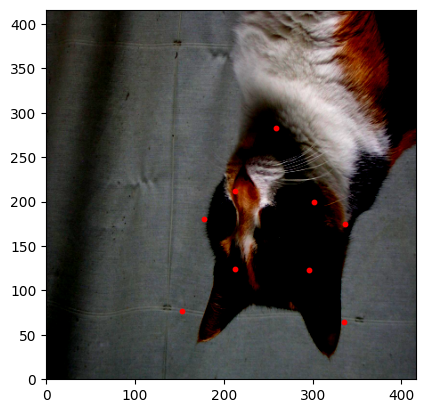

In [75]:
test_images, targets = (test_dataset[310])  
classes, targets =  model(test_images.to(device).to(torch.float32).unsqueeze(0))
test_images = test_images.permute((1,2,0)).numpy()
targets = targets.clone().detach().to("cpu")
pts = targets.squeeze(0)[0]
fig, ax = plt.subplots()
ax.imshow(test_images)
ax.scatter(pts[:, 0], pts[:, 1], c='red', s=10)
ax.set_xlim(0, test_images.shape[1])
ax.set_ylim(0, test_images.shape[0])
plt.show()